# Impact of Air Pollution and Socioeconomic Factors on Mortality Rates

## Project Overview
This notebook analyzes the relationship between air pollution (PM2.5), socioeconomic indicators, and mortality rates across countries.

The goal is to understand whether countries with higher pollution exposure and different income levels experience differences in mortality outcomes.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, f_oneway, ttest_ind

In [35]:
# collect data
pm25_data = pd.read_csv("WorldBank/API_EN.ATM.PM25.MC.M3_DS2_en_csv_v2_6084.csv", skiprows=4)
mortality_data = pd.read_csv("mortality data/IHME-GBD_2023_DATA-fac2f874-1.csv")
metadata = pd.read_csv("WorldBank/Metadata_Country_API_EN.ATM.PM25.MC.M3_DS2_en_csv_v2_6084.csv")

In [36]:
#cleaning pm25 data
year_cols = [col for col in pm25_data.columns if col.isdigit()]
pm25_clean = pm25_data[['Country Name', 'Country Code'] + year_cols]
pm25_long = pd.melt(pm25_clean, id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='PM25')
pm25_long['Year'] = pm25_long['Year'].astype(int)
pm25_2020 = pm25_long[pm25_long['Year'] == 2020].dropna()

In [37]:
#cleaning mortality data
mortality_clean = mortality_data[
    (mortality_data['measure'] == 'Deaths') &
    (mortality_data['sex'] == 'Both') &
    (mortality_data['age'] == 'All ages') &
    (mortality_data['cause'] == 'All causes') &
    (mortality_data['metric'] == 'Rate')
].copy()
mortality_clean = mortality_clean.rename(columns={'location': 'Country Name', 'val': 'Mortality_Rate'})


In [38]:
# celaning metadata
metadata_clean = metadata[['Country Code', 'IncomeGroup']].dropna()

In [39]:
# merging all
df = pd.merge(pm25_2020, metadata_clean, on='Country Code')
df = pd.merge(df, mortality_clean[['Country Name', 'Mortality_Rate']], on='Country Name')
df = df.dropna()

print(f"Final dataset: {len(df)} countries")

Final dataset: 172 countries


In [40]:
# Exploratory Data Analysis
print(df[['PM25', 'Mortality_Rate']].describe())


             PM25  Mortality_Rate
count  172.000000      172.000000
mean    23.342152      788.792872
std     15.335680      267.191443
min      4.895181      103.608219
25%     11.880621      622.770200
50%     19.649015      745.218012
75%     30.111063      968.122204
max     85.122346     1471.835407


In [41]:
print("\n BY INCOME GROUP ")
print(df.groupby('IncomeGroup')[['PM25', 'Mortality_Rate']].mean())


 BY INCOME GROUP 
                          PM25  Mortality_Rate
IncomeGroup                                   
High income          15.477283      869.494132
Low income           40.120445      798.494714
Lower middle income  29.919009      661.875990
Upper middle income  21.056104      787.238204


In [42]:
# hypothesis testing 1
print("HYPOTHESIS TEST 1: PM2.5 vs Mortality Rate")
print("H0: No correlation (ρ = 0)")
print("H1: Significant correlation exists (ρ ≠ 0)")
print("Significance level: α = 0.05\n")

r, p = pearsonr(df['PM25'], df['Mortality_Rate'])
r_squared = r**2

print(f"Pearson's r: {r:.4f}")
print(f"p-value: {p:.4e}")
print(f"R-squared: {r_squared:.4f}")
print(f"Relationship Direction: {'Positive' if r > 0 else 'Negative'}")
print(f"Conclusion: {'Reject H01 (Significant)' if p < 0.05 else 'Fail to Reject H01'}")

if p < 0.05:
    strength = 'strong' if abs(r) > 0.7 else 'moderate' if abs(r) > 0.4 else 'weak'
    print(f"\nInterpretation: There is a {strength}, statistically significant")
    print(f"{'positive' if r > 0 else 'negative'} correlation. R² = {r_squared:.3f}")
    print(f"means PM2.5 explains {r_squared*100:.1f}% of mortality variance.")


HYPOTHESIS TEST 1: PM2.5 vs Mortality Rate
H0: No correlation (ρ = 0)
H1: Significant correlation exists (ρ ≠ 0)
Significance level: α = 0.05

Pearson's r: -0.3386
p-value: 5.5446e-06
R-squared: 0.1146
Relationship Direction: Negative
Conclusion: Reject H01 (Significant)

Interpretation: There is a weak, statistically significant
negative correlation. R² = 0.115
means PM2.5 explains 11.5% of mortality variance.


In [ ]:
# hypothesis testing 2
print("HYPOTHESIS TEST 2: Mortality Across Income Groups")
print("H0: Mean mortality is equal across all income groups")
print("H1: At least one group differs")
print("Significance level: α = 0.05\n")

income_order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']
groups_mortality = [df[df['IncomeGroup']==g]['Mortality_Rate'].values for g in income_order if g in df['IncomeGroup'].unique()]

f_stat, p_val = f_oneway(*groups_mortality)

grand_mean = df['Mortality_Rate'].mean()
ss_between = sum([len(g) * (g.mean() - grand_mean)**2 for g in groups_mortality])
ss_total = sum([(x - grand_mean)**2 for g in groups_mortality for x in g])
eta_squared = ss_between / ss_total

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")
print(f"Effect size (η²): {eta_squared:.4f}")
print(f"Conclusion: {'Reject H02 (Significant)' if p_val < 0.05 else 'Fail to Reject H02'}")

if p_val < 0.05:
    print("\nInterpretation: Mortality rates differ significantly across income groups.")
    print(f"Income level explains about {eta_squared*100:.1f}% of mortality variation.")
else:
    print("\nInterpretation: No significant differences found across income groups.")

HYPOTHESIS TEST 2: Mortality Across Income Groups
H0: Mean mortality is equal across all income groups
H1: At least one group differs
Significance level: α = 0.05

F-statistic: 5.3948
p-value: 1.4375e-03
Effect size (η²): 0.0879
Conclusion: Reject H02 (Significant)

Interpretation: Mortality rates differ significantly across income groups.
Income level explains about 8.8% of mortality variation.


In [ ]:
# hypothesis testing 3
print("HYPOTHESIS TEST 3: PM2.5 Across Income Groups")
print("H0: Mean PM2.5 is equal across all income groups")
print("H1: At least one group differs")
print("Significance level: α = 0.05\n")

groups_pm25 = [df[df['IncomeGroup']==g]['PM25'].values for g in income_order if g in df['IncomeGroup'].unique()]

f_stat_pm25, p_val_pm25 = f_oneway(*groups_pm25)

grand_mean_pm25 = df['PM25'].mean()
ss_between_pm25 = sum([len(g) * (g.mean() - grand_mean_pm25)**2 for g in groups_pm25])
ss_total_pm25 = sum([(x - grand_mean_pm25)**2 for g in groups_pm25 for x in g])
eta_squared_pm25 = ss_between_pm25 / ss_total_pm25

print(f"F-statistic: {f_stat_pm25:.4f}")
print(f"p-value: {p_val_pm25:.4e}")
print(f"Effect size (η²): {eta_squared_pm25:.4f}")
print(f"Conclusion: {'Reject H03 (Significant)' if p_val_pm25 < 0.05 else 'Fail to Reject H03'}")

if p_val_pm25 < 0.05:
    print("\nInterpretation: PM2.5 levels differ significantly across income groups.")
    print(f"Income level explains about {eta_squared_pm25*100:.1f}% of PM2.5 variation.")
else:
    print("\nInterpretation: No significant differences found across income groups.")



HYPOTHESIS TEST 3: PM2.5 Across Income Groups
H0: Mean PM2.5 is equal across all income groups
H1: At least one group differs
Significance level: α = 0.05

F-statistic: 22.5671
p-value: 2.5086e-12
Effect size (η²): 0.2872
Conclusion: Reject H03 (Significant)

Interpretation: PM2.5 levels differ significantly across income groups.
Income level explains about 28.7% of PM2.5 variation.


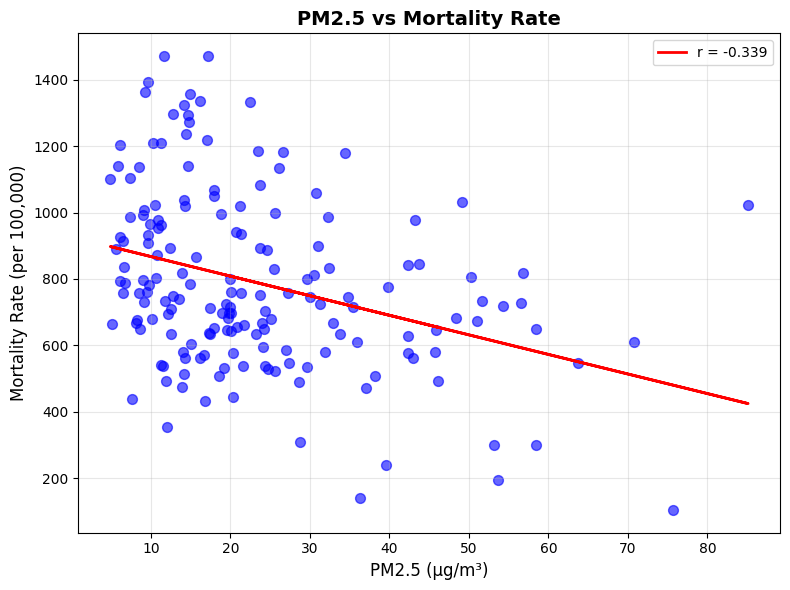

In [ ]:
##  Visualization 1
from scipy.stats import linregress

plt.figure(figsize=(8, 6))
plt.scatter(df['PM25'], df['Mortality_Rate'], color='blue', alpha=0.6, s=50)

slope, intercept, r_value, p_value, std_err = linregress(df['PM25'], df['Mortality_Rate'])
line = slope * df['PM25'] + intercept
plt.plot(df['PM25'], line, color='red', linewidth=2, label=f'r = {r_value:.3f}')

plt.xlabel('PM2.5 (μg/m³)', fontsize=12)
plt.ylabel('Mortality Rate (per 100,000)', fontsize=12)
plt.title('PM2.5 vs Mortality Rate', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('scatter_pm25_mortality.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/bn/x0dxcsgn3c333j90p0dpm0tm0000gn/T/ipykernel_83378/1677227365.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(data_pm25, labels=income_order, patch_artist=True)
/var/folders/bn/x0dxcsgn3c333j90p0dpm0tm0000gn/T/ipykernel_83378/1677227365.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(data_mortality, labels=income_order, patch_artist=True)


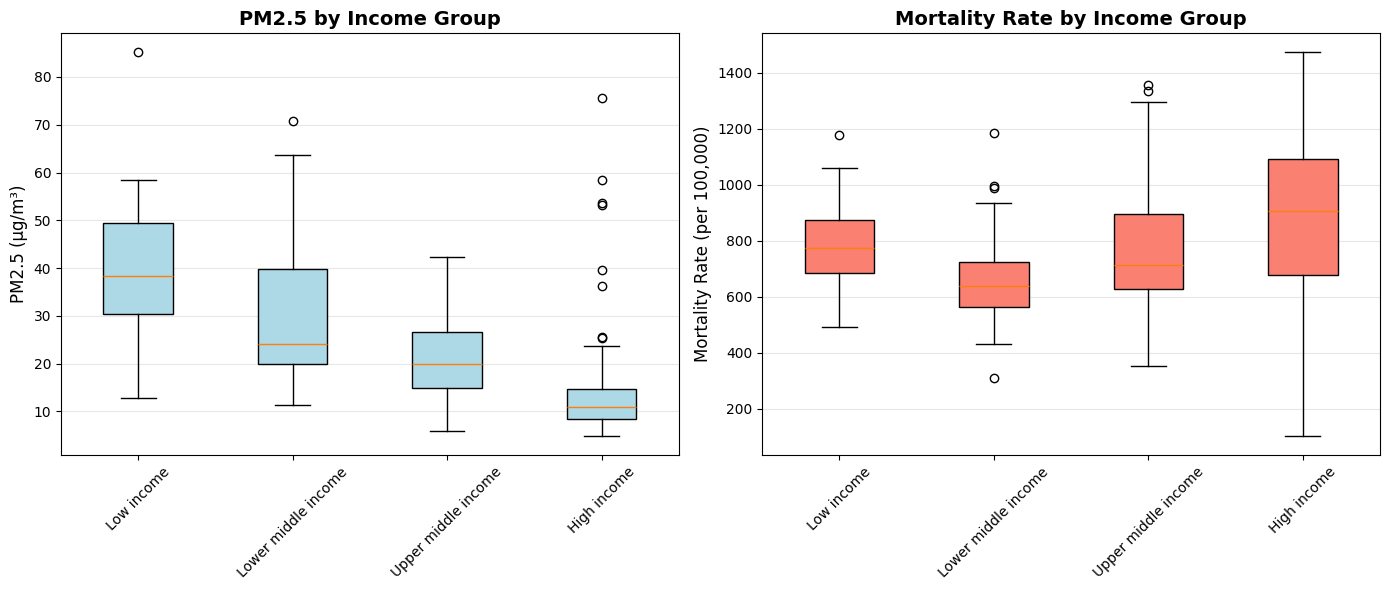

In [ ]:
#  visualization 2 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df_sorted = df[df['IncomeGroup'].isin(income_order)]

data_pm25 = [df_sorted[df_sorted['IncomeGroup']==g]['PM25'].values for g in income_order]
bp1 = axes[0].boxplot(data_pm25, labels=income_order, patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_ylabel('PM2.5 (μg/m³)', fontsize=12)
axes[0].set_title('PM2.5 by Income Group', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

data_mortality = [df_sorted[df_sorted['IncomeGroup']==g]['Mortality_Rate'].values for g in income_order]
bp2 = axes[1].boxplot(data_mortality, labels=income_order, patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('salmon')
axes[1].set_ylabel('Mortality Rate (per 100,000)', fontsize=12)
axes[1].set_title('Mortality Rate by Income Group', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('boxplots_income.png', dpi=300, bbox_inches='tight')
plt.show()

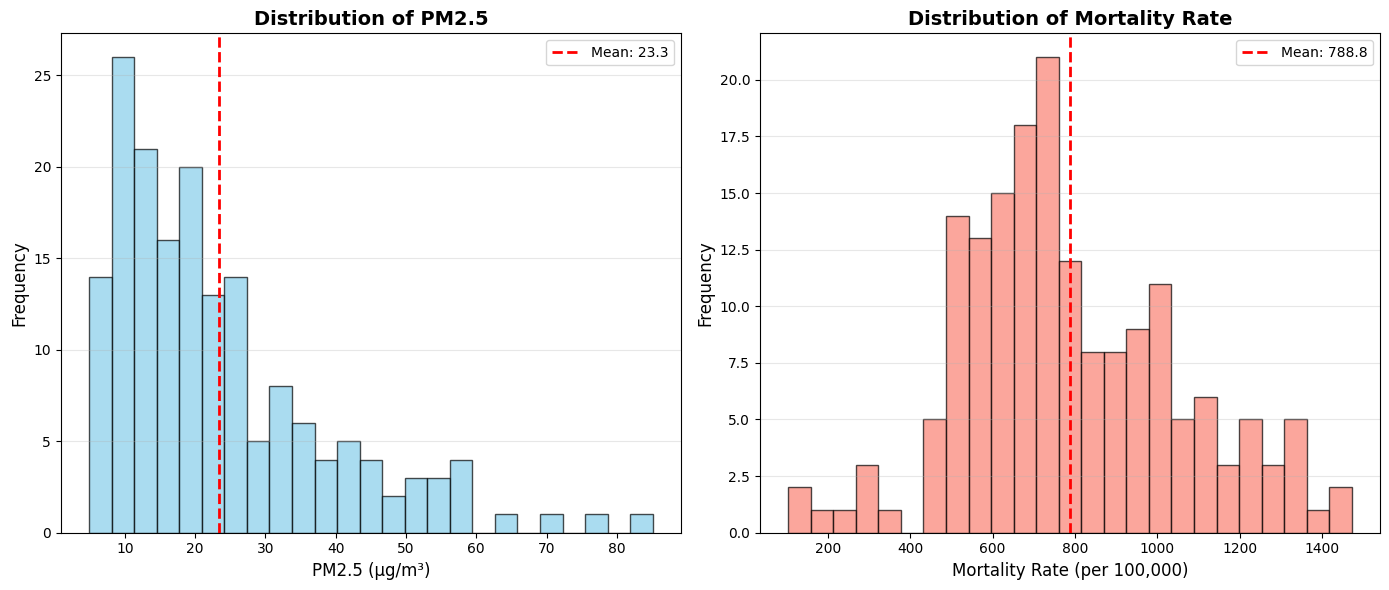

In [ ]:
# visualization 3: histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(df['PM25'], bins=25, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['PM25'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {df["PM25"].mean():.1f}')
axes[0].set_xlabel('PM2.5 (μg/m³)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of PM2.5', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].hist(df['Mortality_Rate'], bins=25, color='salmon', edgecolor='black', alpha=0.7)
axes[1].axvline(df['Mortality_Rate'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {df["Mortality_Rate"].mean():.1f}')
axes[1].set_xlabel('Mortality Rate (per 100,000)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Mortality Rate', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
plt.show()